In [ ]:
# TODO
# GPU + docker

In [234]:
import import_ipynb
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD

from sampler import *

In [275]:
n = 1000

In [276]:
local = sample_no_signalling(n, True)
non_local = sample_no_signalling(n, False)

In [277]:
data = local + non_local
targets = [0] * n + [1] * n

In [278]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, idx):
        x = Image.fromarray(self.data[idx].astype(np.uint8))
        x = self.transform(x)
        y = self.targets[idx]
        return x, y
    
    def __len__(self):
        return len(self.targets)

In [279]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, X, y, transform, num_workers):
        super().__init__()
        self.X = X
        self.y = torch.FloatTensor(y).to(torch.float64)
        self.transform = transform
        self.num_workers = num_workers
        self.num_classes = np.unique(y)
        self.dims = X[0].shape
    
    def setup(self, stage):
        X_train_val, X_test, y_train_val, y_test = train_test_split(self.X, self.y)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val)
        self.train_dataset = MyDataset(X_train, y_train, transform)
        self.test_dataset = MyDataset(X_test, y_test, transform)
        self.val_dataset = MyDataset(X_val, y_val, transform)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=50, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=50, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=50, num_workers=self.num_workers)

In [280]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1600, 100)
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
    
    def features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)

        return self.sigmoid(x)

In [281]:
from torchmetrics import Accuracy
from torch.nn import BCEWithLogitsLoss

class Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = Net()
        self.loss = torch.nn.BCELoss()
        self.acc = Accuracy()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-1)
        
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.model(x)
        y = y.float().unsqueeze(1)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        self.log('train acc', self.acc(torch.round(y_hat), y.int()))
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.model(x)
        y = y.float().unsqueeze(1)
        val_loss = self.loss(y_hat, y)
        self.log('val loss', val_loss)
        self.log('val acc', self.acc(torch.round(y_hat), y.int()))

        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        y = y.float().unsqueeze(1)
        loss = self.loss(y_hat, y)
        output = dict({
            'test_loss': loss,
            'test_acc': self.acc(torch.round(y_hat), y.int()),
        })
        return output

In [282]:
from pl_bolts.callbacks import PrintTableMetricsCallback
from pytorch_lightning.loggers import WandbLogger 
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(100)
])
dm = MyDataModule(data, targets, transform, 16)
clf = Classifier() 
trainer = pl.Trainer(max_epochs=500,
                     gpus=1, callbacks=[PrintTableMetricsCallback2(20)],
                     logger=logger)
trainer.fit(clf, a)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | Net      | 166 K 
1 | loss  | BCELoss  | 0     
2 | acc   | Accuracy | 0     
-----------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.665     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val loss│val acc
────────────────
0.6947027444839478│0.46000000834465027
/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930402517318726│0.5199999809265137│0.6932267546653748│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930394768714905│0.5199999809265137│0.6932255625724792│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930397748947144│0.5199999809265137│0.6932254433631897│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930384635925293│0.5199999809265137│0.693225085735321│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930381655693054│0.5199999809265137│0.6932247877120972│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930369138717651│0.5199999809265137│0.6932241320610046│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930360198020935│0.5199999809265137│0.6932240128517151│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930350065231323│0.5199999809265137│0.6932236552238464│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930328011512756│0.5199999809265137│0.6932225823402405│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930317282676697│0.5199999809265137│0.6932222247123718│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930326223373413│0.5199999809265137│0.6932222247123718│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930316090583801│0.5199999809265137│0.6932216882705688│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930303573608398│0.5199999809265137│0.6932213306427002│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930292844772339│0.5199999809265137│0.6932206749916077│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930283904075623│0.5199999809265137│0.6932201385498047│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930273175239563│0.5199999809265137│0.6932194232940674│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930245757102966│0.5199999809265137│0.6932181715965271│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930232048034668│0.5199999809265137│0.6932172775268555│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930239200592041│0.5199999809265137│0.6932172179222107│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930225491523743│0.5199999809265137│0.6932163238525391│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930215358734131│0.5199999809265137│0.6932154297828674│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930198669433594│0.5199999809265137│0.6932145953178406│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930181980133057│0.5199999809265137│0.6932135224342346│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.6930165886878967│0.5199999809265137│0.69321209192276│0.4906666576862335


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.693014919757843│0.5199999809265137│0.6932106018066406│0.4906666576862335


In [226]:
from torchvision.datasets import MNIST
from torch.utils.data import random_split

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./', batch_size=32):

        super().__init__()

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = 10
        self.dims = (1, 28, 28)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(100)
            #transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform,
                               target_transform=lambda x: float(x<5))
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform,
                                   target_transform=lambda x: float(x<5))

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [202]:
from pl_bolts.callbacks.printing import dicts_to_table

  
import copy
from itertools import zip_longest
from typing import Any, Callable, Dict, List, Optional

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.utilities import rank_zero_info


class PrintTableMetricsCallback2(Callback):
    def __init__(self, display_every_n_epochs) -> None:
        self.metrics: List = []
        self.iter = 0
        self.display_every_n_epochs = display_every_n_epochs
            
    def on_train_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:        
        if self.iter % (2  * self.display_every_n_epochs) == 0:
            metrics_dict = copy.copy(trainer.callback_metrics)
            rank_zero_info(dicts_to_table([metrics_dict]))            
        self.iter += 1

In [ ]:
class CheckBatchGradient(pl.Callback):
    
    def on_train_start(self, trainer, model):
        n = 0

        example_input = model.example_input_array.to(model.device)
        example_input.requires_grad = True

        model.zero_grad()
        output = model(example_input)
        output[n].abs().sum().backward()
        
        zero_grad_inds = list(range(example_input.size(0)))
        zero_grad_inds.pop(n)
        
        if example_input.grad[zero_grad_inds].abs().sum().item() > 0:
            raise RuntimeError("Your model mixes data across the batch dimension!")           

In [285]:
a = clf.model.features(next(iter(dm.train_dataloader()))[0])

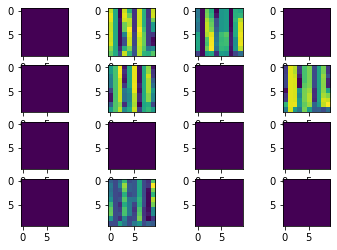

In [289]:
plt.figure(figsize=(8, 8))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.imshow(a[0,i,:,:].detach().numpy())

In [297]:
from pl_bolts.callbacks import PrintTableMetricsCallback
from pytorch_lightning.loggers import WandbLogger 
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(100)
])
dm = MNISTDataModule()
clf2 = Classifier() 
trainer = pl.Trainer(max_epochs=25,
                     gpus=1, callbacks=[PrintTableMetricsCallback2(20)],
                     logger=logger)
trainer.fit(clf2, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | Net      | 166 K 
1 | loss  | BCELoss  | 0     
2 | acc   | Accuracy | 0     
-----------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.665     Total estimated model params size (MB)


aaa
w sreo


Validation sanity check: 0it [00:00, ?it/s]

val loss│val acc
────────────────
0.6946313381195068│0.453125


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_loss│train acc│val loss│val acc
─────────────────────────────────────
0.01851929910480976│1.0│0.08308538049459457│0.974399983882904


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [298]:
features = clf2.model.features(next(iter(dm.train_dataloader()))[0])

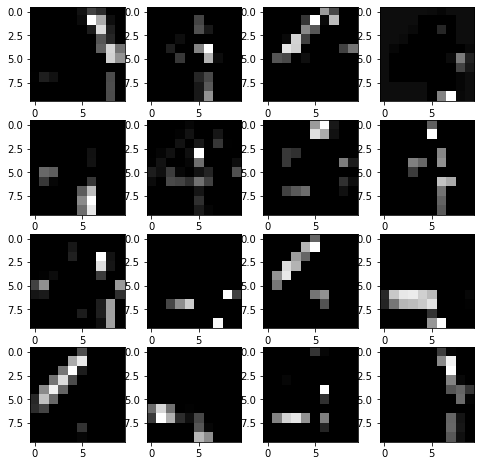

In [301]:
plt.figure(figsize=(8, 8))
for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.imshow(features[2,i,:,:].detach().numpy(), cmap='gray')

In [302]:
next(iter(dm.train_dataloader()))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..